#  <center> Taller  de Aprendizaje Automático </center>
##  <center> Taller 2: Críticas de Cine  </center>

Esta actividad constituye un primer acercamiento al campo de aprendizaje automático conocido como NLP (Natural Language Processing). En particular, exploraremos el campo conocido como *sentiment analysis* que consiste en determinar el sentimiento subyacente en un texto.  En este caso clasificaremos las críticas realizadas por los usuarios a las películas como positivas o negativas. 

## Objetivos Generales del Taller

 - Entender la importancia de la limpieza y el preprocesamiento de los datos en el *pipeline* de aprendizaje 
 - Construir, a partir de documentos de texto, vectores de características que puedan ser utilizados por clasificadores. 
 - Generar un *pipeline* que permita clasificar una crítica como positiva o negativa utilizando técnicas clásicas de procesamiento de lenguaje natural.
 


## Formas de trabajo

#### Opción 1: Trabajar localmente

##### Descarga de datos disponibles en Kaggle

Luego, para descargar el dataset de IMDb reviews:

In [1]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


Descomprima el archivo descargado:

In [2]:
import shutil
shutil.unpack_archive('./imdb-dataset-of-50k-movie-reviews.zip', './')

In [3]:
#!unzip imdb-dataset-of-50k-movie-reviews.zip

#### Opción 2:  Trabajar en *Colab*. 

Se puede trabajar en Google Colab. Para ello es necesario contar con una cuenta de **google drive** y ejecutar un notebook almacenado en dicha cuenta. De lo contrario, no se conservarán los cambios realizados en la sesión. En caso de ya contar con una cuenta, se puede abrir el notebook y luego ir a `Archivo-->Guardar una copia en drive`. 

La siguiente celda monta el disco personal del drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A continuación, vaya a su cuenta de [Kaggle](https://www.kaggle.com/) (o cree una si aún no lo ha hecho), haga clic en el icono de perfil en la esquina superior derecha de la pantalla y seleccione "Your Account" en la lista desplegable. Luego, seleccione la viñeta "Account" y haga clic en "Create new API token". Entonces un archivo llamado kaggle.json se descargará automáticamente a su carpeta de descargas. Este archivo contiene sus credenciales de inicio de sesión para permitirle acceder a la API.

La siguiente celda realiza la configuración necesaria para obtener datos desde la plataforma Kaggle. Le solicitará que suba el archivo kaggle.json descargado anteriormente.

In [2]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# El siguiente archivo solicitado es para habilitar la API de Kaggle en el entorno que está trabajando.
# Este archivo se descarga entrando a su perfíl de Kaggle, en la sección API, presionando donde dice: Create New API Token

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


Una vez guardado el *token* se pueden descargar los datos, en este caso se bajarán los datos del dataset IMDb reviews:

In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 58% 15.0M/25.7M [00:00<00:00, 152MB/s]
100% 25.7M/25.7M [00:00<00:00, 189MB/s]


In [4]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/TAA-fing/TAA-2023/blob/main/talleres/taller2_criticas_cine.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Ejecutar en Google Colab</a>
  </td>
</table>

## Paquetes a utilizar

En esta actividad se utilizarán algunas bibliotecas auxiliares que deberán ser instaladas. Ejecutar la siguiente celda hasta que se ejecute sin errores. En caso de error, se puede instalar el paquete faltante desde el notebook con el comando:

`!pip install paquete_faltante`

In [ ]:
!pip install comet_ml

In [ ]:
!pip install nltk

In [5]:
#import comet_ml in the top of your file
from comet_ml import Experiment
import numpy as np
import sklearn
import pandas as pd
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import re # regular expressions library
import nltk # natural language processing toolkit

## Parte 1 - Carga de datos

Se trabajará con una base de datos de 50000 críticas obtenidas del sitio Internet Movie Database (IMDb), dicha base de datos fue presentada originalmente en el artículo [Learning Word Vectors for Sentiment Analysis, A. L. Maas, R. E. Daly, P. T. Pham, D.Huang, A. Y. Ng, and C. Potts, Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies, pages 142–150, Portland, Oregon, USA, Association for Computational Linguistics, June 2011](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf) y se encuentra disponible en [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). En esta actividad se trabajará con los datos disponibles en Kaggle.    

Cada una de las críticas fue clasificada como *positive* si el usuario la puntuó con seis o más estrellas y *negative* en caso contrario.

#### Objetivos:

 - Descargar la base de datos y levantar los datos.
 - Ejecutar la función `show_word_clouds()` provista sobre los datos levantados. La función asume que los datos se cargaron en un DataFrame.

In [6]:
def show_word_clouds(data, stopwords=None):
    
    '''
    Entrada:
        data: DataFrame de pandas con las críticas y su evaluación
        stopwords: palabras que por ser muy comunes y/o
                   poco informativas no se tomarán en cuenta al realizar la nube
    '''
    
    pos=' '.join(map(str,data['review'][data['sentiment']=='positive']))
    neg=' '.join(map(str,data['review'][data['sentiment']=='negative']))

    positive_cloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(pos) 
    
    negative_cloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(neg) 

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(positive_cloud)
    plt.title('Sentimento positivo')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(negative_cloud)
    plt.title('Sentimento negativo')
    plt.axis('off')

In [7]:
import zipfile 
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
IMDB_dataset = pd.read_csv('IMDB Dataset.csv')

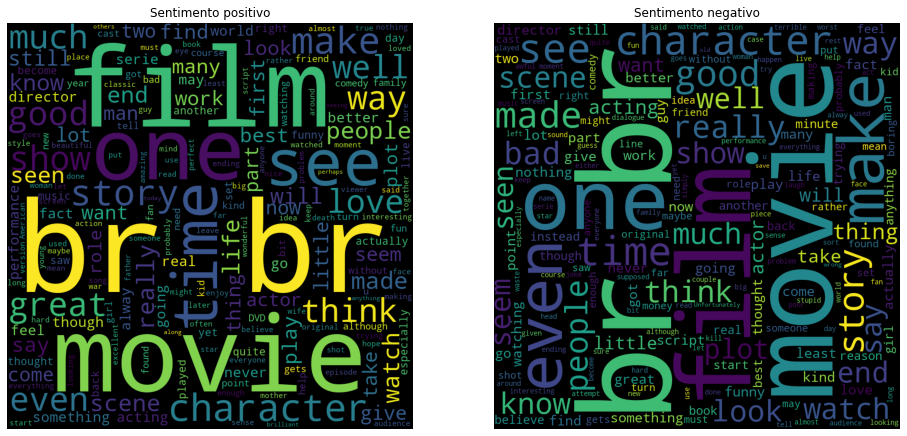

In [24]:
show_word_clouds(IMDB_dataset)

In [25]:
IMDB_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Parte 2 - Limpieza del texto

Las *nubes de palabras* de la parte anterior sugieren que puede ser buena idea realizar un preprocesamiento de los datos ya que, por ejemplo:
   - Se obsevan tags html entre las palabras mostradas      
   - Hay palabras muy comunes que aparecen en ambas categorías      
   - Algunas palabras no parecen relevantes   

Se realizará un preprocesamiento de los datos de forma de eliminar los **tags html**. Para ello se utilizará la [biblioteca](https://docs.python.org/3.7/library/re.html) de expresiones regulares de Python. La utilización de las expresiones regulares para este fin es un tanto [controversial](https://stackoverflow.com/questions/1732348/regex-match-open-tags-except-xhtml-self-contained-tags/1732454#1732454) pero a los efectos de esta actividad es totalmente adecuado. 

Las expresiones regulares son una herramienta muy potente pero que requiere de cierto tiempo para familiarizarse con sus reglas. En este [link](https://developers.google.com/edu/python/regular-expressions) hay un buen tutorial de Google.  En esta primera versión el preprocesamiento hará las siguientes tareas:
- Se eliminan los **tags html** .  
- Se eliminan caracteres *non-words*. Se consideran *words* a las letras, los dígitos y la barra baja.       
- Se pasará el texto a minúsculas
    
Como ejemplo se muestra la crítica del usuario número 50, antes y después de eliminar los **tags html**. 

In [9]:
def simple_preprocessor(text):
    text = re.sub('<.*?>','',text)      # se eliminan los tags html
    text = re.sub('[\W]+', ' ', text)  # se eliminan caracteres 'non-words' 
                                        # Words characters are  a letter or digit or underbar [a-zA-Z0-9_].)
    text = text.lower()                #
    return text

In [10]:
review_50 = 'Return to the 36th Chamber is one of those classic Kung-Fu movies which Shaw produces back in the 70s and 80s, whose genre is equivalent to the spaghetti westerns of Hollywood, and the protagonist Gordon Liu, the counterpart to the western\'s Clint Eastwood. Digitally remastered and a new print made for the Fantastic Film Fest, this is "Presented in Shaw Scope", just like the good old days.<br /><br />This film is a simple story of good versus evil, told in 3 acts, which more or less sums up the narrative of martial arts films in that era.<br /><br />Act One sets up the premise. Workers in a dye-mill of a small village are unhappy with their lot, having their wages cut by 20% by incoming manchu gangsters. They can\'t do much about their exploitation because none of them are martial arts skilled to take on the gangsters, and their boss. At first they had a minor success in getting Liu to impersonate a highly skilled Shaolin monk (one of the best comedy sequences), but their rouse got exposed when they pushed the limit of credibility by impersonating one too many times.<br /><br />Act Two shows the protagonist wanting to get back at the mob. However, without real martial arts, he embarks on a journey to Shaolin Temple, to try and infiltrate and learn martial arts on the sly. After some slapstick moments, he finally gets accepted by the abbot (whom he impersonated!) but is disappointed at the teaching methods - kinda like Mr Miyagi\'s style in Karate Kid, but instead of painting fences, he gets to erect scaffoldings all around the temple. Nothing can keep a good man down, and he unwittingly builds strength, endurance and learns kung-fu the unorthodox way.<br /><br />Act Three is where the fight fest begins. With cheesy sound effects, each obvious non-contact on film is given the maximum impact treatment. But it is rather refreshing watching the fight scenes here, with its wide angled shots to highlight clarity and detail between the sparring partners, and the use of slow-motion only to showcase stunts in different angles. You may find the speed of fights a tad too slow, with some pause in between moves, but with Yuen Wo Ping and his style being used ad-nausem in Hollywood flicks, they sure don\'t make fight scenes like they used to! Return to the 36th chamber gets a repeat screening on Monday, so, if you\'re game for a nostalgic trip down memory lane, what are you waiting for?'
print(review_50)

Return to the 36th Chamber is one of those classic Kung-Fu movies which Shaw produces back in the 70s and 80s, whose genre is equivalent to the spaghetti westerns of Hollywood, and the protagonist Gordon Liu, the counterpart to the western's Clint Eastwood. Digitally remastered and a new print made for the Fantastic Film Fest, this is "Presented in Shaw Scope", just like the good old days.<br /><br />This film is a simple story of good versus evil, told in 3 acts, which more or less sums up the narrative of martial arts films in that era.<br /><br />Act One sets up the premise. Workers in a dye-mill of a small village are unhappy with their lot, having their wages cut by 20% by incoming manchu gangsters. They can't do much about their exploitation because none of them are martial arts skilled to take on the gangsters, and their boss. At first they had a minor success in getting Liu to impersonate a highly skilled Shaolin monk (one of the best comedy sequences), but their rouse got expo

In [11]:
review_50_after = simple_preprocessor(review_50)
print(review_50_after)

return to the 36th chamber is one of those classic kung fu movies which shaw produces back in the 70s and 80s whose genre is equivalent to the spaghetti westerns of hollywood and the protagonist gordon liu the counterpart to the western s clint eastwood digitally remastered and a new print made for the fantastic film fest this is presented in shaw scope just like the good old days this film is a simple story of good versus evil told in 3 acts which more or less sums up the narrative of martial arts films in that era act one sets up the premise workers in a dye mill of a small village are unhappy with their lot having their wages cut by 20 by incoming manchu gangsters they can t do much about their exploitation because none of them are martial arts skilled to take on the gangsters and their boss at first they had a minor success in getting liu to impersonate a highly skilled shaolin monk one of the best comedy sequences but their rouse got exposed when they pushed the limit of credibili

### Preprocesamiento básico

 - Preprocesar todas las revisiones
 - Verificar el correcto funcionamiento visualizando las *nubes de palabras* después de preprocesar.

In [12]:
dataset_review = IMDB_dataset.review.apply(simple_preprocessor)
IMDB_dataset_new = IMDB_dataset.copy()
IMDB_dataset_new.review = dataset_review
IMDB_dataset_new.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is a...,positive


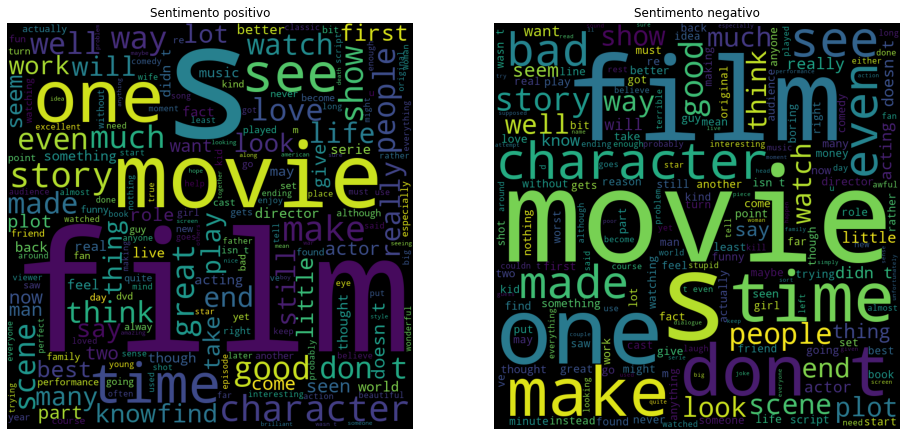

In [30]:
show_word_clouds(IMDB_dataset_new)

In [13]:
mapping = {'negative': 0, 'positive': 1}
IMDB_dataset_new = IMDB_dataset_new.replace({'sentiment': mapping})

In [14]:
IMDB_dataset_new

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,i am a catholic taught in parochial elementary...,0
49998,i m going to have to disagree with the previou...,0


## Parte 3 - De documentos de texto a matrices numéricas

### Tokens

Al proceso de pasar de un texto a su separación en palabras se le llama *tokenization*. La forma más simple de hacerlo es separarlo utilizando como límites de separación los espacios en blanco.  Por ejemplo:

In [15]:
def simple_tokenizer(text):
    return text.split()

In [16]:
sample_text = 'the actor seem to enjoy acting in every act'
print(simple_tokenizer(sample_text))

['the', 'actor', 'seem', 'to', 'enjoy', 'acting', 'in', 'every', 'act']


### Modelo Bag of Words

El modelo *bag-of-words* es una forma de transformar una secuencia de palabras en en un vector de características numérico que pueda ser utilizado por un clasificador. En una de sus versiones más utilizados el procedimiento consiste en:

1. Crear un diccionario de palabras 
2. Construir el vector de características de cada documento con las veces que aparece cada palabra del diccionario en el documento. 

En general la cantidad de palabras en el diccionario va a ser mayor que la cantidad de palabras únicas en el texto por lo que la representación se dice que es *sparse*, mayormente ceros en el vector de características.

Afortunadamente *sklearn* cuenta con el módulo [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) que construye el modelo bag-of-words por nosotros. 

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


In [18]:
print(X.toarray())

[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [19]:
IMDB_dataset_new_reviewsvectorized = vectorizer.fit_transform(IMDB_dataset_new.review)
print(vectorizer.get_feature_names_out())

['00' '000' '00000000000' ... 'żmijewski' 'יגאל' 'כרמון']


### Subconjuntos de Entrenamiento y Test

#### Objetivos:

 - Dividir el conjunto de datos disponibles de forma de utilizar las primeras 35000 muestras para entrenamiento y reservar el resto para test.

In [20]:
IMDB_dataset_train_X = IMDB_dataset_new.review[0:35000]
IMDB_dataset_train_Y = IMDB_dataset_new.sentiment[0:35000]

IMDB_dataset_test_X = IMDB_dataset_new.review[35000:]
IMDB_dataset_test_Y = IMDB_dataset_new.sentiment[35000:]

IMDB_dataset_train_Y

0        1
1        1
2        1
3        0
4        1
        ..
34995    0
34996    0
34997    0
34998    1
34999    0
Name: sentiment, Length: 35000, dtype: int64

## Parte 4 - Un primer pipeline

#### Objetivos:

 - Construir un **pipeline** que:
      1. Tome como entrada los datos luego de realizar una limpieza básica de los mismos.
      2. Genere el modelo *bag-of-words*.
      3. Realice una clasificación de los mismos utilizando el clasificador de *regresión logística*.
      
      
 - Evalúe su desempeño utilizando diferentes métricas, por ejemplo: *precision*, *recall*, *accuracy*. 

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, accuracy_score, precision_score


In [22]:
pipeline_FP = Pipeline([("vectorizer", CountVectorizer()), ("regression", LogisticRegression())])

In [23]:
pipeline_FP.fit(IMDB_dataset_train_X, IMDB_dataset_train_Y)

c:\Users\Javo\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('regression', LogisticRegression())])

In [24]:
score = pipeline_FP.score(IMDB_dataset_test_X, IMDB_dataset_test_Y)

recall = recall_score(IMDB_dataset_test_Y, pipeline_FP.predict(IMDB_dataset_test_X))

precision = precision_score(IMDB_dataset_test_Y, pipeline_FP.predict(IMDB_dataset_test_X))

accuracy = accuracy_score(IMDB_dataset_test_Y, pipeline_FP.predict(IMDB_dataset_test_X))

print("Training metrics:")

print(pipeline_FP.score(IMDB_dataset_train_X, IMDB_dataset_train_Y), "SCORE")

print(recall_score(IMDB_dataset_train_Y, pipeline_FP.predict(IMDB_dataset_train_X)), "RECALL")

print(precision_score(IMDB_dataset_train_Y, pipeline_FP.predict(IMDB_dataset_train_X)), "PRECISION")

print(accuracy_score(IMDB_dataset_train_Y, pipeline_FP.predict(IMDB_dataset_train_X)), "ACCURACY")

print("Testing metrics:")

print(pipeline_FP.score(IMDB_dataset_test_X, IMDB_dataset_test_Y), "SCORE")

print(recall_score(IMDB_dataset_test_Y, pipeline_FP.predict(IMDB_dataset_test_X)), "RECALL")

print(precision_score(IMDB_dataset_test_Y, pipeline_FP.predict(IMDB_dataset_test_X)), "PRECISION")

print(accuracy_score(IMDB_dataset_test_Y, pipeline_FP.predict(IMDB_dataset_test_X)), "ACCURACY")

Training metrics:
0.9721428571428572 SCORE
0.9737564322469983 RECALL
0.9705932638057788 PRECISION
0.9721428571428572 ACCURACY
Testing metrics:
0.8908 SCORE
0.8909454061251665 RECALL
0.8909454061251665 PRECISION
0.8908 ACCURACY


### Registrado de Experimentos en Comet

[Documentación](https://www.comet.ml/docs/python-sdk/Experiment/) de funciones para registrar los experimentos.

In [25]:
from sklearn.model_selection import cross_validate

In [26]:
def save_results(cmt_exp, cross_val_results):
    '''
    Entrada:
        cmt_exp: experimento comet
        cross_val_scores: scikit-learn cross validation results
    '''

    ### Registro de Métricas de Evaluación ###
    fit_time = cross_val_results['fit_time']
    cv_accuracy = cross_val_results['test_accuracy']
    cv_precision = cross_val_results['test_precision']
    cv_recall = cross_val_results['test_recall']
   
    ### Resultados para cada fold ###
    for k in range(fit_time.size):
        metrics_step = {
            'Fit Time':fit_time[k],
            'Accuracy':cv_accuracy[k],
            'Precision':cv_precision[k],
            'Recall':cv_recall[k],
        }
        cmt_exp.log_metrics(metrics_step,step=k)

    ### Registro de Gráficas ###
    plt.figure()
    plt.plot(cross_val_results['test_accuracy'],'*-')
    plt.xlabel('fold')
    plt.ylabel('Accuracy')
    plt.title('Cross validation accuracy')
    plt.grid()
    
    cmt_exp.log_figure(figure_name="CV_Acc" ,figure=plt)
   
    return

In [27]:
API_KEY = '155G536Yi5H0GQ90JpLPYX4MV' # Se puede encontrar en Settings(Arriba a la derecha en Comet)

In [32]:
#Crear un experimento con tu API KEY
exp = Experiment(api_key=API_KEY,  
                 project_name='movie_reviews', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp.set_name('Parte 4') # Nombre de este experimento
exp.add_tags(['Básico']) # Tags

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/njavo/movie-reviews/437c4578075f4528a7cc174f3ba66f24



In [33]:
basic_pipeline_scores = cross_validate(pipeline_FP, IMDB_dataset_train_X, IMDB_dataset_train_Y, scoring=['accuracy', 'precision', 'recall'],return_estimator=True)

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/njavo/movie-reviews/437c4578075f4528a7cc174f3ba66f24
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Accuracy [5]  : (0.8804285714285714, 0.8861428571428571)
COMET INFO:     Fit Time [5]  : (17.86302137374878, 27.847883224487305)
COMET INFO:     Precision [5] : (0.8742616033755274, 0.8906566387040786)
COMET INFO:     Recall [5]    : (0.8802172670097198, 0.888507718696398)
COMET INFO:   Others:
COMET INFO:     Name : Parte 4
COMET INFO:   Parameters:
COMET INFO:     memory                        : 1
COMET INFO:     modelo                        : basico
COME

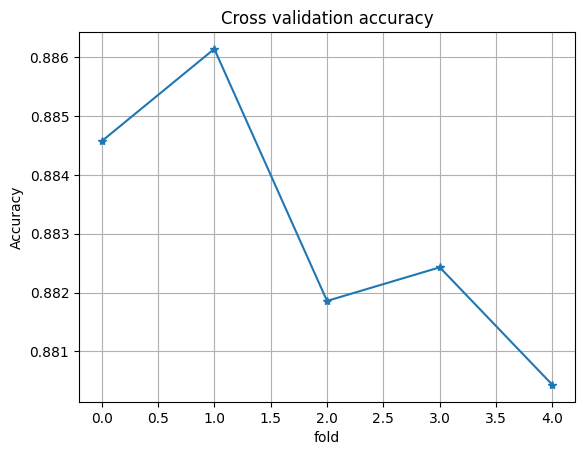

In [34]:
exp.log_parameters(pipeline_FP.get_params())
exp.log_parameter("modelo","basico")
save_results(exp,basic_pipeline_scores)
exp.end()

## Parte 5 - Stop-words

*Stop-words* son aquellas palabras que son extremadamente comunes y que por tanto es poco probable que contengan información relevante para clasificar documentos. La biblioteca **NLTK** cuenta con un conjunto de 127 *stop-words* que pueden obtenerse de la siguiente manera:

In [28]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_english = stopwords.words('english')
print(stop_words_english)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Javo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
languages = stopwords.fileids()

# Initialize an empty set to store the stopwords
stop_words = set()

# Iterate through each language and add its stopwords to the stop_words set
for language in languages:
    stop_words.update(stopwords.words(language))
stop_words = list(stop_words)

print(stop_words)

['cand', 'masihkah', 'sekecil', 'біреу', '甚么', 'गरी', 'minden', 'boli', 'aaya', 'қабл', '而且', 'česar', 'míg', 'अक्सर', 'petinosemdesetem', 'yoxsa', 'כאן', 'dekha', 'petintridesetega', 'δαί', 'dimaksudnya', 'vere', '产生', 'people', 'najini', 'ҳу', '倘然', 'av', 'देखिन्छ', 'voor', 'êtes', 'ط', 'quin', 'nekim', 'әлдеқалай', 'kateregakoli', 'алатау', 'गरेका', 'estarán', 'le-tistem', 'buat', '不一', 'কাউকে', 'às', 'সেটাই', 'inni', 'yakin', 'масқарай', 'сіздер', 'أولاء', 'менің', '其余', 'disinilah', 'looks', 'suatu', 'কিছুই', 'को', '从而', 'usse', 'ghar', 'магар ', 'عشرون', 'never', 'rakha', 'it', 'zanj', 'peterima', "that'll", 'kar', 'দেখে', 'keiltä', 'somehow', 'onun', 'হলেও', "we'd", 'nikogar', 'فيم', 'osmo', 'לאו', 'eras', 'ক্ষেত্রে', 'érem', 'এখানে', 'ছাড়া', 'furono', 'altfel', 'pet', 'desi', 'heidät', 'triintrideseti', 'nekakemu', 'hay', 'naokoli', 'niistä', 'sedemindvajseto', 'هم', '彼此', 'hajam', 'سبت', 'won', 'kunne', 'inn', 'enakih', 'selama', 'qədər', 'о', 'above', 'isə', 'asupra', 'emme'

#### Objetivos:

 - Modificar el **pipeline** de la parte anterior de forma tal que no utilice las **stops-words** definidas por **nltk**.

In [46]:
pipeline_SP = Pipeline([('vectorizer', CountVectorizer(stop_words = stop_words_english)),('regresion', LogisticRegression())])

In [47]:
pipeline_SP.fit(IMDB_dataset_train_X, IMDB_dataset_train_Y)

c:\Users\Javo\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('regresion', LogisticRegression())])

In [48]:
score = pipeline_SP.score(IMDB_dataset_test_X, IMDB_dataset_test_Y)

recall = recall_score(IMDB_dataset_test_Y, pipeline_SP.predict(IMDB_dataset_test_X))

precision = precision_score(IMDB_dataset_test_Y, pipeline_SP.predict(IMDB_dataset_test_X))

accuracy = accuracy_score(IMDB_dataset_test_Y, pipeline_SP.predict(IMDB_dataset_test_X))

print(score, "SCORE")

print(recall, "RECALL")

print(precision, "PRECISION")

print(accuracy, "ACCURACY")

0.8858666666666667 SCORE
0.8854860186418109 RECALL
0.8864302852572647 PRECISION
0.8858666666666667 ACCURACY


In [49]:
pipeline_TP = Pipeline([('vectorizer', CountVectorizer(stop_words = stop_words)),('regresion', LogisticRegression())])

In [50]:
pipeline_TP.fit(IMDB_dataset_train_X, IMDB_dataset_train_Y)

c:\Users\Javo\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаң

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['və', 'liya', 'isə', 'হয়েই',
                                             'geweest', 'sakti', 'dvojnim',
                                             'sedan', 'агар', 'tistimi',
                                             'marsikatera', 'haben', 'خمسة',
                                             'bolte', 'adica', 'tämä', '其二',
                                             'vsema', 'takihle', 'prvi', 'båe',
                                             'তিনি', 'sai', 'mîine',
                                             'diantaranya', 'šestnajstih',
                                             'conseguir', 'eût', 'cita', 'أنشأ', ...])),
                ('regresion', LogisticRegression())])

In [51]:
score = pipeline_TP.score(IMDB_dataset_test_X, IMDB_dataset_test_Y)

recall = recall_score(IMDB_dataset_test_Y, pipeline_TP.predict(IMDB_dataset_test_X))

precision = precision_score(IMDB_dataset_test_Y, pipeline_TP.predict(IMDB_dataset_test_X))

accuracy = accuracy_score(IMDB_dataset_test_Y, pipeline_TP.predict(IMDB_dataset_test_X))

print(score, "SCORE")

print(recall, "RECALL")

print(precision, "PRECISION")

print(accuracy, "ACCURACY")

0.8788 SCORE
0.8801597869507324 RECALL
0.8780552603613178 PRECISION
0.8788 ACCURACY


In [43]:
#Crear un experimento con tu API KEY
exp = Experiment(api_key=API_KEY,  
                 project_name='movie_reviews', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp.set_name('Parte 5 - English') # Nombre de este experimento
exp.add_tags(['Stop words English']) # Tags

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/njavo/movie-reviews/75fd1b379114466eae8b2cc0d12b94c3



In [44]:
basic_pipeline_scores_1 = cross_validate(pipeline_SP, IMDB_dataset_train_X, IMDB_dataset_train_Y, scoring=['accuracy', 'precision', 'recall'],return_estimator=True)

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/njavo/movie-reviews/75fd1b379114466eae8b2cc0d12b94c3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Accuracy [5]  : (0.8784285714285714, 0.8848571428571429)
COMET INFO:     Fit Time [5]  : (14.85962724685669, 17.138622045516968)
COMET INFO:     Precision [5] : (0.8733821046707935, 0.8813031161473088)
COMET INFO:     Recall [5]    : (0.8810748999428245, 0.8893653516295026)
COMET INFO:   Others:
COMET INFO:     Name : Parte 5 - English
COMET INFO:   Parameters:
COMET INFO:     memory                       : 1
COMET INFO:     modelo                       : ba

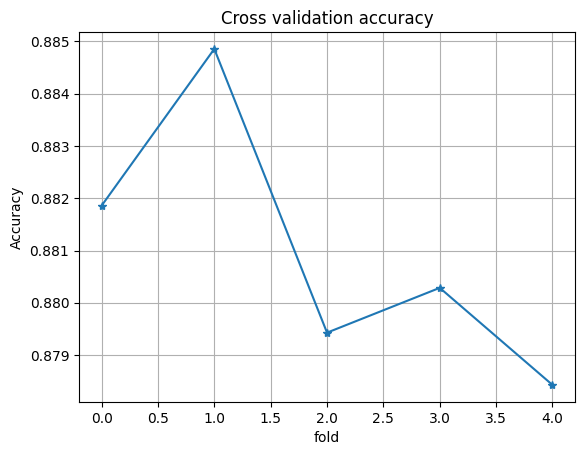

In [45]:
exp.log_parameters(pipeline_SP.get_params())
exp.log_parameter("modelo","basico")
save_results(exp,basic_pipeline_scores_1)
exp.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/njavo/movie-reviews/f44a273df91447fb929ff18d1a63d7ab

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/njavo/movie-reviews/f44a273df91447fb929ff18d1a63d7ab
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Accuracy [5]  : (0.8

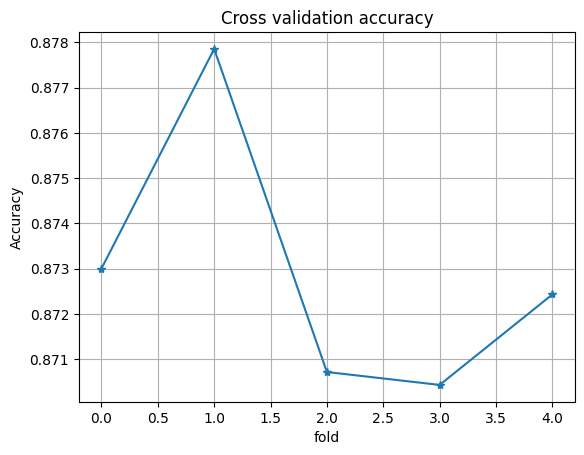

In [46]:
#Crear un experimento con tu API KEY
exp = Experiment(api_key=API_KEY,  
                 project_name='movie_reviews', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp.set_name('Parte 5 - Global') # Nombre de este experimento
exp.add_tags(['Stop words Global']) # Tags

basic_pipeline_scores_2 = cross_validate(pipeline_TP, IMDB_dataset_train_X, IMDB_dataset_train_Y, scoring=['accuracy', 'precision', 'recall'],return_estimator=True)

exp.log_parameters(pipeline_TP.get_params())
exp.log_parameter("modelo","basico")
save_results(exp,basic_pipeline_scores_2)
exp.end()

## Parte 6 - Tf-Idf : Ponderando la relevancia de las palabras

La eliminación de **stop-words** es una forma de considerar que determinadas palabras no son relevantes para la tarea que se quiere realizar. Otra forma de hacerlo, algo más específica, es la técnica conocida como **tf-idf**, del inglés *term frequency - inverse document frequency*. La idea detrás del método es quitarle peso a las palabras que aparecen frecuentemente en los textos que se quieren analizar. Se define como el producto entre la frecuencia con que aparece una palabra en el texto que se quiere analizar y el inverso de la frecuencia con que aparece en todo el conjunto de datos disponible.

$$
\textit{tf-id}(t,d)= \textit{tf}(t,d) \times \textit{idf}(t,d)
$$

El primer término del producto $\textit{tf}(t, d)$ es la cantidad de veces que la palabra *t* aparece en el documento *d* que se quiere analizar. El segundo término $\textit{idf}(t, d)$ es el inverso de la frecuencia del documento que se calcula:

$$
\textit{idf}(t,d)=\log \frac{n_d}{1+df(d,t)}
$$

donde $n_d$ es el número total de documentos y $\textit{df}(d, t)$ es el número de documentos que contienen la palabra $t$. Existen variantes en cuanto a la fórmula exacta que se utiliza en las distintas implementaciones. Por ejemplo, la adición de 1 en el denominador se realizar para evitar la división entre cero al analizar palabras que no aparecen en el conjunto de entrenamiento. El logaritmo se usa para no darle demasiado peso a los documentos menos frecuentes.

#### Objetivos:

 - Modificar el **pipeline** de forma de tomar en cuenta la frecuencia con que aparecen las palabras. Para ello utilizar la clase *TfidTransformer* de *scikit-learn*. 

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

pipeline_FP = Pipeline([
    ('vectorizer', CountVectorizer(stop_words=stop_words_english)),
    ('tfidf', TfidfTransformer()),  # Add the TfidfTransformer step
    ('regression', LogisticRegression())
])

pipeline_FP.fit(IMDB_dataset_train_X, IMDB_dataset_train_Y)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('tfidf', TfidfTransformer()),
                ('regression', LogisticRegression())])

In [31]:
score = pipeline_FP.score(IMDB_dataset_test_X, IMDB_dataset_test_Y)

recall = recall_score(IMDB_dataset_test_Y, pipeline_FP.predict(IMDB_dataset_test_X))

precision = precision_score(IMDB_dataset_test_Y, pipeline_FP.predict(IMDB_dataset_test_X))

accuracy = accuracy_score(IMDB_dataset_test_Y, pipeline_FP.predict(IMDB_dataset_test_X))

print(score, "SCORE")

print(recall, "RECALL")

print(precision, "PRECISION")

print(accuracy, "ACCURACY")

0.8972666666666667 SCORE
0.9071904127829561 RECALL
0.8897740629489356 PRECISION
0.8972666666666667 ACCURACY


In [54]:
pipeline_5P = Pipeline([
    ('vectorizer', CountVectorizer(stop_words=stop_words)),
    ('tfidf', TfidfTransformer()),  # Add the TfidfTransformer step
    ('regression', LogisticRegression())
])

pipeline_5P.fit(IMDB_dataset_train_X, IMDB_dataset_train_Y)

c:\Users\Javo\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаң

Pipeline(steps=[('vectorizer',
                 CountVectorizer(stop_words=['və', 'liya', 'isə', 'হয়েই',
                                             'geweest', 'sakti', 'dvojnim',
                                             'sedan', 'агар', 'tistimi',
                                             'marsikatera', 'haben', 'خمسة',
                                             'bolte', 'adica', 'tämä', '其二',
                                             'vsema', 'takihle', 'prvi', 'båe',
                                             'তিনি', 'sai', 'mîine',
                                             'diantaranya', 'šestnajstih',
                                             'conseguir', 'eût', 'cita', 'أنشأ', ...])),
                ('tfidf', TfidfTransformer()),
                ('regression', LogisticRegression())])

In [55]:
score = pipeline_5P.score(IMDB_dataset_test_X, IMDB_dataset_test_Y)

recall = recall_score(IMDB_dataset_test_Y, pipeline_5P.predict(IMDB_dataset_test_X))

precision = precision_score(IMDB_dataset_test_Y, pipeline_5P.predict(IMDB_dataset_test_X))

accuracy = accuracy_score(IMDB_dataset_test_Y, pipeline_5P.predict(IMDB_dataset_test_X))

print(score, "SCORE")

print(recall, "RECALL")

print(precision, "PRECISION")

print(accuracy, "ACCURACY")

0.8913333333333333 SCORE
0.9043941411451398 RECALL
0.881619937694704 PRECISION
0.8913333333333333 ACCURACY


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'c:\\Users\\Javo\\Desktop\\TAA\\taller_2' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/njavo/movie-reviews/f06546c9afc24229b3bfdfcb152eabb6

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/njavo/movie-reviews/f06546c9afc24229b3bfdfcb152eabb6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Accuracy [5]  : (0.8902857142857142, 0.8951428571428

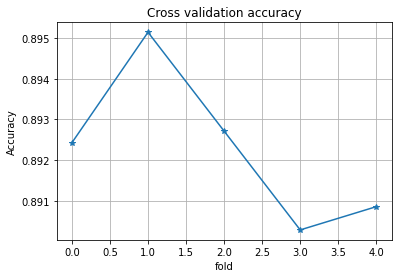

In [32]:
#Crear un experimento con tu API KEY
exp = Experiment(api_key=API_KEY,  
                 project_name='movie_reviews', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp.set_name('Parte 6 - English') # Nombre de este experimento
exp.add_tags(['TF-ldf English']) # Tags

basic_pipeline_scores = cross_validate(pipeline_FP, IMDB_dataset_train_X, IMDB_dataset_train_Y, scoring=['accuracy', 'precision', 'recall'],return_estimator=True)

exp.log_parameters(pipeline_FP.get_params())
exp.log_parameter("modelo","basico")
save_results(exp,basic_pipeline_scores)
exp.end()

## Parte 7 - N-gramas

El modelo *bag-of-words* que se presentó anteriormente se conoce también como *unigrama* ya que cada elemento del diccionario se corresponde con una sola palabra. Una extensión de este modelo es considerar como un elemento a toda secuencia de *n-palabras* que aparezca en el texto, a esta representación se la conoce como *n-grama*. 

En el texto 'This is the first document', por ejemplo, los elementos que se generan en las distintas representaciones son los siguientes: 
- 1-grama: 'This', 'is', 'the', 'first', 'document'
- 2-grama: 'This is', 'is the', 'the first', 'first document'

#### Objetivos:

 - Modificar el *pipeline* de la **Parte 4 - Un primer pipeline** de forma de generar un modelo *2-grama* o *bigrama*.

In [56]:
pipeline_6P = Pipeline([
    ('vectorizer', CountVectorizer(stop_words=stop_words_english, ngram_range=(1, 2))),  # Update ngram_range to (1, 2)
    ('tfidf', TfidfTransformer()),  
    ('regression', LogisticRegression())
])

pipeline_6P.fit(IMDB_dataset_train_X, IMDB_dataset_train_Y)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('tfidf', TfidfTransformer()),
                ('regression', LogisticRegression())])

In [57]:
score = pipeline_6P.score(IMDB_dataset_test_X, IMDB_dataset_test_Y)

recall = recall_score(IMDB_dataset_test_Y, pipeline_6P.predict(IMDB_dataset_test_X))

precision = precision_score(IMDB_dataset_test_Y, pipeline_6P.predict(IMDB_dataset_test_X))

accuracy = accuracy_score(IMDB_dataset_test_Y, pipeline_6P.predict(IMDB_dataset_test_X))

print(score, "SCORE")

print(recall, "RECALL")

print(precision, "PRECISION")

print(accuracy, "ACCURACY")

0.8925333333333333 SCORE
0.9061251664447404 RECALL
0.8823910788381742 PRECISION
0.8925333333333333 ACCURACY


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/njavo/movie-reviews/33eb03756a9045398ea0300a29af5e63

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/njavo/movie-reviews/33eb03756a9045398ea0300a29af5e63
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Accuracy [5]  : (0.8

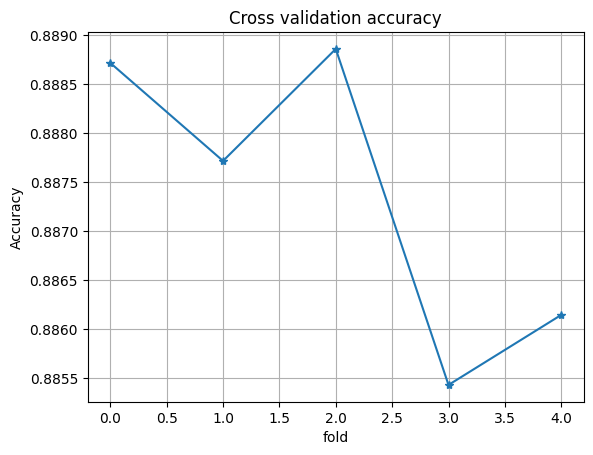

In [59]:
#Crear un experimento con tu API KEY
exp = Experiment(api_key=API_KEY,  
                 project_name='movie_reviews', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp.set_name('Parte 7 - English') # Nombre de este experimento
exp.add_tags(['Bigram English']) # Tags

basic_pipeline_scores = cross_validate(pipeline_6P, IMDB_dataset_train_X, IMDB_dataset_train_Y, scoring=['accuracy', 'precision', 'recall'],return_estimator=True)

exp.log_parameters(pipeline_6P.get_params())
exp.log_parameter("modelo","basico")
save_results(exp,basic_pipeline_scores)
exp.end()

## Parte 8 - Generar un modelo

#### Objetivos:

 - Generar el mejor modelo posible utilizando **solamente** los datos del conjunto de entrenamiento. Se podrá explorar posibles mejoras en cualquiera de las siguientes etapas:

    - Limpieza y preprocesamiento de los datos (*ej.* Contracciones *don't*$\rightarrow$*do not*)
    - Lemmatization (ver final)(puede explorarse los distintos Stemmers de la librería *nltk*)
    - Modelo n-gramas (*Sugerencia:* tomar en cuenta más de un n-grama a la vez, probar limitar el tamaño del diccionario `max_features`)
    - Parámetros óptimos del clasificador

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')

In [34]:
def custom_tokenizer(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos="a") for token in tokens]
    return lemmatized_tokens

pipeline_7P = Pipeline([
    ('vectorizer', CountVectorizer(stop_words=stop_words_english, tokenizer=custom_tokenizer)),
    ('tfidf', TfidfTransformer()),  
    ('regression', LogisticRegression())
])

param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer__max_features': [1000, 5000, 10000, 20000],
    'regression__C': [0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline_7P, param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(IMDB_dataset_train_X, IMDB_dataset_train_Y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters: ", best_params)
print("Best score: ", best_score)

best_pipeline = grid_search.best_estimator_

NameError: name 'GridSearchCV' is not defined

In [60]:
score = best_pipeline.score(IMDB_dataset_test_X, IMDB_dataset_test_Y)

recall = recall_score(IMDB_dataset_test_Y, best_pipeline.predict(IMDB_dataset_test_X))

precision = precision_score(IMDB_dataset_test_Y, best_pipeline.predict(IMDB_dataset_test_X))

accuracy = accuracy_score(IMDB_dataset_test_Y, best_pipeline.predict(IMDB_dataset_test_X))

print(score, "SCORE")

print(recall, "RECALL")

print(precision, "PRECISION")

print(accuracy, "ACCURACY")

0.9038666666666667 SCORE
0.9091877496671105 RECALL
0.8998418555614127 PRECISION
0.9038666666666667 ACCURACY


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/njavo/movie-reviews/71349f6b856b43ecaf79d2747dcd84fc
COMET INFO:   Others:
COMET INFO:     Name : Parte 8 - English
COMET INFO:   Parameters:
COMET INFO:     memory                        : 1
COMET INFO:     modelo                        : basico
COMET INFO:     regression                    : LogisticRegression(C=10)
COMET INFO:     regression__C                 : 10
COMET INFO:     regression__class_weight      : 1
COMET INFO:     regression__dual              : False
COMET INFO:     regression__fit_intercept     : True
COMET INFO:     regression__intercept_scaling : 1
COMET INFO:     regression__l1_ratio          : 1
COMET IN

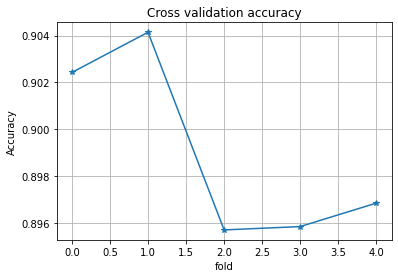

In [64]:
#Crear un experimento con tu API KEY
API_KEY = '155G536Yi5H0GQ90JpLPYX4MV'
exp = Experiment(api_key=API_KEY,  
                 project_name='movie_reviews', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False) 
exp.set_name('Parte 8 - English') # Nombre de este experimento
exp.add_tags(['Stop words English']) # Tags

basic_pipeline_scores_2 = cross_validate(best_pipeline, IMDB_dataset_train_X, IMDB_dataset_train_Y, scoring=['accuracy', 'precision', 'recall'],return_estimator=True)

exp.log_parameters(best_pipeline.get_params())
exp.log_parameter("modelo","basico")
save_results(exp,basic_pipeline_scores_2)
exp.end()

## Parte 9 - Entrega del modelo y evaluación con el conjunto reservado para test

#### Objetivos:

 - Guardar el mejor modelo encontrado
 - Evaluar el accuracy con el conjunto de test.

In [ ]:
import pickle

# Save the models to disk
with open('best_logistic_regression.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)

In [39]:
import pickle
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def custom_tokenizer(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos="a") for token in tokens]
    return lemmatized_tokens

with open('best_logistic_regression.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [40]:
from sklearn.metrics import accuracy_score

test_predictions = loaded_model.predict(IMDB_dataset_test_X)

test_accuracy = accuracy_score(IMDB_dataset_test_Y, test_predictions)

print(f"Accuracy en el conjunto de test: {test_accuracy:.3f}")

c:\Users\Javo\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


Accuracy en el conjunto de test: 0.904


## Parte 10 - Lemmatization (Opcional)

Al separar las palabras con espacios en blancos, palabras derivadas de una misma raíz toman diferentes codificaciones. Desde un punto de vista semántico es preferible que estas palabras se agrupen en su raíz común. Este procedimiento se conoce como *stemming*. Uno de los problemas que tienen los *stemmers* es que pueden crear palabras no existentes. La técnica conocida como *lemmatization* busca encontrar palabras raíces gramaticalmente correctas, llamadas *lemmas*. Estas técnicas son computacionalmente más complejas.

In [60]:
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [61]:
lemmatizer = WordNetLemmatizer()
sentence= "good better bad worse great greatest"
sentence_words = simple_tokenizer(sentence)

print("{0:20}{1:20}".format("Word","Lemma"))
for word in sentence_words:
    print ("{0:20}{1:20}".format(word,lemmatizer.lemmatize(word,pos="a")))

Word                Lemma               
good                good                
better              good                
bad                 bad                 
worse               bad                 
great               great               
greatest            great               


#### Objetivos:

 - Modificar el *pipeline* de la **Parte 4 - Un primer pipeline** de forma de generar un modelo que incluya *Lemmatization*.